# Robustness of new tree using DE genes specific to group 1 (source DE genes) and the ones specific to group 4 and 5 (target DE genes)

In [32]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import community 
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import random
import itertools

# Import custom libraries
import pcst_robustness as pcst

In [33]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_robustness' from '/home/braunger/masterthesis/python_code/PCST/pcst_robustness.py'>

In [34]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
tf_dir = "/home/braunger/masterthesis/save/TF_targets/"
de_dir = "/home/braunger/masterthesis/save/DE_genes/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

In [41]:
net_dict = pcst.get_net_dir_all_stages(save_dir, "allTFs", "200", design = 1)
steps = ["1-15_16-26_27-60"]
net_stats_d1, target_counts = pcst.compare_networks(net_dict, data_dir, fig_dir, save_dir, steps,
                                                 TFs_with_targets = True, design = 1)
incl_TFs = [tf[:-4] for tf in net_stats_d1.iloc[0, 9]]

net_stats_d1.iloc[:, 0:8]

TF target cost:  0.01


,n_nodes,n_edges,n_incl_terminals,percent_incl_terminals,n_Steiner_nodes,n_TFs,n_incl_TFs,n_prized_TFs
1-15_16-26_27-60,552,6087,279,92.384106,273,249,64,1


## Compare bridge TFs to the ones from S1, S2 and S3

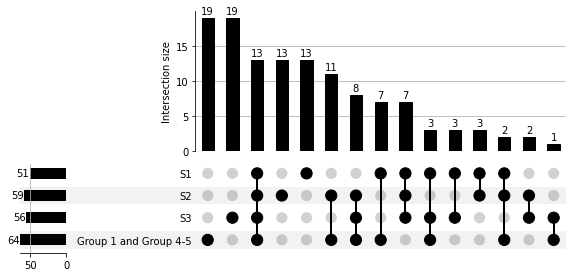

In [36]:
# load bridge TFs from design 2 networks
TF_groups = pd.read_csv(save_dir+'incl_TFs_design2.csv')

intersections = from_contents({'Group 1 and Group 4-5': incl_TFs,
                               'S3': TF_groups.loc[TF_groups['net'] == 'old_net', 'TF'], 
                               'S2': TF_groups.loc[TF_groups['net'] == 'middle_net', 'TF'],
                               'S1': TF_groups.loc[TF_groups['net'] == 'young_net', 'TF']})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 1, sort_categories_by=None).plot()

plt.savefig(fig_dir+'upset_new_pcst_group1_group45.png', dpi = 500, bbox_inches="tight")

## Get TFs centrality

In [45]:
# load all TF targets
all_tf_targets = pd.read_csv(tf_dir+'TF_targets_anno.csv')
all_genes = pd.read_csv(de_dir+'all_genes.csv')
all_tf_targets = all_tf_targets[all_tf_targets['target'].isin(all_genes['gene'])]

TFs_centrality = pd.DataFrame(columns = ['TF', 'katz_centrality', 'PPIs', 'DE_targets', 'all_targets'])

# calculate Katz centrality for each node in the network
# largest eigenvalue phi
net = net_dict["200.allTFs.1-15_16-26_27-60"]
phi = np.max(np.abs(np.linalg.eigh(np.array(nx.adjacency_matrix(net).todense()))[0]))
centrality = nx.katz_centrality(net, alpha=1/phi-0.01)
for TF in incl_TFs:
    neighbors = [n[-1] for n in net.neighbors(TF + '_tr0')]
    n_targets = all_tf_targets[all_tf_targets['TF'] == TF].shape[0]
    row = pd.DataFrame({'TF': [TF],  
                        'katz_centrality': centrality[TF+ '_tr0'],
                        'PPIs': [neighbors.count('0')], 
                        'DE_targets': [neighbors.count('1')], 
                        'all_targets': [n_targets]})
    TFs_centrality = pd.concat([TFs_centrality, row], ignore_index = True)

In [46]:
TFs_centrality.head()

,TF,katz_centrality,PPIs,DE_targets,all_targets
0,OGT,0.050204,34,2,144
1,BRCA1,0.074838,52,22,2371
2,SRC,0.087148,100,4,1185
3,MAFK,0.038529,11,9,713
4,YY1,0.069378,45,21,2780


## Significant bridge TFs

In [51]:
# Hypergeometric parameters N and K
N = all_genes.shape[0] # total number of genes
K = [node[-1] for node in net.nodes()].count('1') # total number of DE genes

# Sequence of hyper geometric parameter n
q_list = np.logspace(-4,0,1000)
n_list = [int(q*N) for q in q_list]

# Lower and upper bound of (right-sided) CI
alpha = 0.05/DE_genes.shape[0] # level of confidence interval
ci_lowerbound = np.repeat(0, len(q_list))
ci_upperbound = np.array([ss.hypergeom.ppf(1-alpha, N, K, n, loc=0) for n in n_list])/K

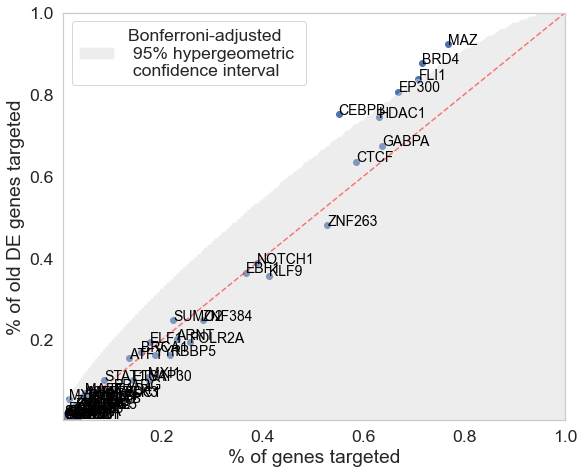

In [52]:
# Plot TFs on prop_genome_targets - prop_DE_targets space for one network
TF_percent_targets = TFs_centrality.copy()
TF_percent_targets['prop_genome_targets'] = TF_percent_targets['all_targets'] / N
TF_percent_targets['prop_DE_targets'] = TF_percent_targets['DE_targets'] / K
TF_percent_targets = TF_percent_targets.set_index('TF')

sns.set(font_scale=1.6)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize=(9,7.5))
x = TF_percent_targets['prop_genome_targets']
y = TF_percent_targets['prop_DE_targets']
labels = TF_percent_targets.index.values
ax.scatter(x, y)
ax.plot((0,1),(0,1), color='red', linestyle='dashed', alpha=0.5)
ax.fill_between(q_list, ci_lowerbound, ci_upperbound, where=None, facecolor='lightgrey', 
                interpolate=False, alpha=0.4, 
                label='Bonferroni-adjusted \n 95% hypergeometric \n confidence interval')
for i in range(TF_percent_targets.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=14, color='black')
plt.xlabel('% of genes targeted')
plt.ylabel('% of old DE genes targeted')
plt.legend(loc='upper left')
plt.xlim([4e-3,1])
plt.ylim([3e-3,1])
plt.savefig(fig_dir+'hypergeom_G45_bridge_TFs.png', dpi = 500, bbox_inches="tight")
plt.show()

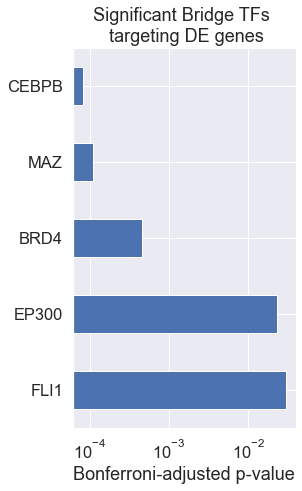

Number of significant TFs = 5


In [58]:
# Compute adjusted p-values
pvals = [ss.hypergeom.sf(TF_percent_targets.loc[tf,'prop_DE_targets']*K, 
                         N, 
                         K, 
                         TF_percent_targets.loc[tf,'prop_genome_targets']*N)*K
         for tf in TF_percent_targets.index]
TF_p_values = pd.concat(
    [TF_percent_targets, pd.DataFrame({'adj_pval': pvals}, index=TF_percent_targets.index)], 
    axis=1
)
TF_p_values['adj_pval'] = TF_p_values['adj_pval'].fillna(1)

# Barplot of significant TFs
TF_p_values = TF_p_values.sort_values(by='adj_pval', ascending=False)

sns.set(font_scale=1.5)
plt.figure(figsize=(4,7))
TF_p_values[TF_p_values['adj_pval']<0.05]['adj_pval'].plot.barh()
plt.xscale('log')
plt.xlabel('Bonferroni-adjusted p-value')
plt.ylabel('')
plt.title('Significant Bridge TFs \n targeting DE genes')
plt.savefig(fig_dir+'signif_group45_TFs.png', dpi = 500, bbox_inches="tight")
plt.show()

significant_tfs = TF_p_values[TF_p_values['adj_pval']<0.05].index.values
print(f'Number of significant TFs = {len(significant_tfs)}')

# Save df containing the adjusted p-values
TF_p_values['TF'] = TF_p_values.index.values
TF_p_values.to_csv(save_dir + 'TFs_centrality_group45.csv', index = False)

In [59]:
TF_p_values.head()

,katz_centrality,PPIs,DE_targets,all_targets,prop_genome_targets,prop_DE_targets,adj_pval,TF
TF,,,,,,,,
ELK3,0.031395,3,8,1891,0.126421,0.062016,127.303708,ELK3
SAP30,0.037066,7,13,2602,0.173954,0.100775,127.166346,SAP30
KAT5,0.059237,42,4,1237,0.082698,0.031008,127.039930,KAT5
SRC,0.087148,100,4,1185,0.079222,0.031008,126.294678,SRC
MXI1,0.036123,4,14,2572,0.171948,0.108527,125.032227,MXI1
